<center>

*******************************************************************************************

<font size="4">
Wavelet Coherence Transform<br>
</font>

##### 10 September 2025

##### Juan Ignacio Mendoza Garay
*******************************************************************************************

</center>

##### INFORMATION:

* The Wavelet Coherence Transform (WCT) measures the time-frequency relationship between two periodic signals at different time-scales.
>
* Dependencies:
    * [PyCWT](https://github.com/regeirk/pycwt)
    * [Matlab](https://se.mathworks.com/products/matlab.html)
    * [Matlab Engine for Python](https://se.mathworks.com/help/matlab/matlab_external/install-the-matlab-engine-for-python.html)
    * 
>
* Tested with:
    * Python 3.11
    * Matlab 2024b
    * Windows 11
>
* References:
    * Torrence, C., & Compo, G. P. (1998). A practical guide to wavelet analysis. *Bulletin of the American Meteorological society, 79*(1), 61-78.
    * Krieger, S., & Freij, N. (2024). *PyCWT: Wavelet spectral analysis in Python*. https://github.com/regeirk/pycwt
    * [*PyCWT* documentation](https://pycwt.readthedocs.io)
    * Grinsted, A., Moore, J. C., & Jevrejeva, S. (2004). *Application of the cross wavelet transform and wavelet coherence to geophysical time series. Nonlinear processes in geophysics, 11*(5/6), 561-566.
    * [*wcoherence* documentation](https://se.mathworks.com/help/wavelet/ref/wcoherence.html)
>
* Instructions:
    * Ensure that the dependecies are installed.
    * Edit the values indicated with an arrow like this: <---
    * Run the program, close your eyes, and hope for the best.

*******************************************************************************************

In [1]:
import sys
import pycwt
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

matlab_connected = False

***
### Generate synthetic data

#### Define functions

In [2]:
def make_supersine(argdict):
    '''
    Produce a sine wave with optional variables for distortion.
    Arg:
        wavargs = dict()
        Required values:
            wavargs['frequency']: scalar (Hz)
            wavargs['phase_shift']: scalar or scalar * numpy.pi
            wavargs['amplitude']: scalar
            wavargs['sampling_frequency']: scalar (Hz or fps)
            wavargs['length']: int (number of samples or frames)
        Optional values:
            wavargs['vertical_offset']: scalar
            wavargs['irregularity']: scalar in [0...1]
            wavargs['noise_strength']: scalar in [0...1]
            wavargs['seed'] = s
    Returns:
        array
    '''
    from scipy.interpolate import CubicSpline

    f = argdict.get('frequency')
    ps = argdict.get('phase_shift')
    amp = argdict.get('amplitude')
    fps = argdict.get('sampling_frequency')
    l = argdict.get('length')
    v_offset = argdict.get('vertical_offset',0)
    irregularity = argdict.get('irregularity',0)
    noise_strength = argdict.get('noise_strength',0)
    noise_strength = noise_strength
    ranseed = argdict.get('seed',None)

    if irregularity or noise_strength:
        rangen = np.random.default_rng(seed=ranseed)
    t = np.arange(0, l)/fps
    y = np.sin(2*np.pi*f*t + ps/2)
    if irregularity:
        if irregularity >= 1:
            y = np.zeros(l)
        else:
            n_ran = int(np.ceil((l-2) * (1-irregularity)**2))
            if n_ran < 1: n_ran = 1
            ran_idx = np.sort(rangen.choice(np.arange(1,l), size=n_ran, replace=False))
            ip_x = np.insert(ran_idx, [0,n_ran], [0,l])
            ip_y = y[ran_idx]
            ip_y = ip_y - ip_y * rangen.random(size=ip_y.shape[0]) * irregularity**2
            ip_y = np.insert(ip_y, [0,n_ran], [0,0])
            ipf = CubicSpline(ip_x,ip_y)
            y = ipf(np.arange(l))
    if noise_strength > 0:
        noiz = rangen.uniform(-0.9,0.9,l)
        y = (y - (y * noiz * noise_strength ))
    y = (y * amp) / (np.max( [ abs(y.min()) , y.max() ] ) * 2)
    y = y + v_offset
    return y

In [3]:
def make_testdata(**kwargs):
    '''
    Generate synthetic data for testing functions that measure synchronisation.
    or a dictionary resulting from that function. All arguments are keywords.
    Args:
        Optional kwargs:
            fps (int): Frames per second.
            durations_sections (list[int]): Durations of sections in seconds.
            n_points (int): Number of oscillating points.
            point_vars (numpy.ndarray):
                axes = sections, points, axes, vars
                vars = frequency, phase shift, amplitude, dc offset, irregularity, noise strength
            n_axes (int): Number of spatial axes.
            seed (int): Seed for the pseudorandom generator (e.g., for reproducibility).
            nan (bool): True returns array 'data_vars' as NaN. False returns default values.
            verbose: display values for variales, except 'data_vars' (see Returns below).
    Returns:
        N-D array with dimensions [points,axes,frames]
    '''

    fps = kwargs.get('fps')
    durations_sections = kwargs.get('durations_sections')
    total_duration = kwargs.get('total_duration')
    n_axes = testdata_vars['n_axes']
    n_points = testdata_vars['n_points']
    point_vars = kwargs.get('point_vars') # dim = [sections,points,axes,vars]
    rseed = kwargs.get('seed',None)
    # vars = frequency, phase_shift, amplitude, vertical_offset, irregularity, noise_strength

    test_data = np.empty((n_points,n_axes,total_duration)) # dim = [points,axes,frames]
    i_start_section = 0
    for i_s,s in enumerate(point_vars):
        n_frames = durations_sections[i_s] * fps
        i_end_section = i_start_section + n_frames
        for i_p,p in enumerate(s):
            for i_ax,ax in enumerate(p):
                wavargs = {}
                wavargs['frequency'] = ax[0]
                wavargs['phase_shift'] = ax[1]
                wavargs['amplitude'] = ax[2]
                wavargs['sampling_frequency'] = fps
                wavargs['length'] = n_frames
                wavargs['vertical_offset'] = ax[3]
                wavargs['irregularity']  = ax[4]
                wavargs['noise_strength'] = ax[5]
                wavargs['seed'] = rseed
                test_data[i_p,i_ax,i_start_section:i_end_section] = make_supersine(wavargs)
        i_start_section = i_end_section
    return test_data

>
#### Generate data

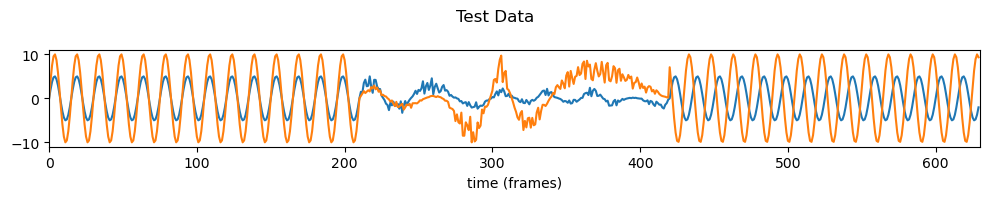

In [4]:
bl_f = 2  # <--- baseline frequency (Hz)
seed = 4  # <--- pseudorandom generator's seed

testdata_vars = { 'fps':30,'durations_sections':[7,7,7], 'n_points':2,'n_axes':1 }
testdata_vars['total_duration'] = sum(testdata_vars['durations_sections']) * testdata_vars['fps']
testdata_vars['point_vars'] = np.empty(( len(testdata_vars['durations_sections']),
                                         testdata_vars['n_points'], testdata_vars['n_axes'],6 ))

# vars = frequency, phase_shift, amplitude, vertical_offset, irregularity, noise_strength
# section 0:
testdata_vars['point_vars'][0,0,0] = 1, 0,   10, 0, 0, 0
testdata_vars['point_vars'][0,1,0] = 1, 0,   20, 0, 0, 0
# section 1:
testdata_vars['point_vars'][1,0,0] = 1, 0.2, 10, 0, 0.72, 0.8
testdata_vars['point_vars'][1,1,0] = 1, 0.7, 20, 0, 0.78, 0.5
# section 2:
testdata_vars['point_vars'][2,0,0] = 1, 0,         10, 0, 0, 0
testdata_vars['point_vars'][2,1,0] = 1, 3*np.pi/2, 20, 0, 0, 0

testdata_vars['point_vars'][[0,2],...,0] = bl_f

test_data_0 = make_testdata(**testdata_vars)

plt.figure(figsize=(10,2))
for s in test_data_0[:,0,:]:
    plt.plot(s)
    plt.xlim((0,testdata_vars['total_duration']))
plt.xlabel('time (frames)')
plt.suptitle('Test Data')
plt.tight_layout();

Sections:
1. in synchrony, different amplitude
2. random oscillation
3. constant phase difference, different amplitude (same as 1)

***
### Wavelet Coherence Transform

In [5]:
minmaxf = [1,10]     # <--- [minimum, maximum] frequency (Hz), can be the same

wct_method = 'pycwt' # <--- 'pycwt' or 'matlab'
# wct_method = 'matlab' # <--- 'pycwt' or 'matlab'

if wct_method == 'pycwt':

    dt = 1/testdata_vars['fps']
    flambda = pycwt.Morlet().flambda()
    s0 = 1/(flambda*minmaxf[1])
    dj=1/12
    J = np.floor(np.log2( minmaxf[1]/minmaxf[0] ) / dj)

    WCT, _, coi, freq_out, _ = pycwt.wct( test_data_0[0,0,:], test_data_0[1,0,:],
                                          dt, dj=dj, s0=s0, J=J,
                                          wavelet='morlet', normalize=False, sig=False )

elif wct_method == 'matlab':

    if matlab_connected: print('Already connected to Matlab.')
    else: # allow to run sc.ptdata.gxwt multiple times without reconnecting to Matlab
        import matlab.engine
        print('Connecting to Matlab...')
        matlabeng = matlab.engine.start_matlab()
        print('...connected to Matlab version',matlabeng.version())
        matlab_connected = True

    freq_lim = matlab.double([minmaxf[0],minmaxf[1]])
    WCT, _, freq_out, coi = matlabeng.wcoherence( test_data_0[0,0,:], test_data_0[1,0,:],
                                                  testdata_vars['fps'],'FrequencyLimits', freq_lim,
                                                  'VoicesPerOctave', 12, nargout=4 )

    WCT = np.array(WCT)
    freq_out = np.array(freq_out).T[0]
    coi = 1/np.array(coi)[0]

else: raise Exception('wrong wct_method')

print('n_scales = ',len(freq_out))
print('f_scales (Hz) =',freq_out)

n_scales =  40
f_scales (Hz) = [10.          9.43874313  8.90898718  8.40896415  7.93700526  7.49153538
  7.07106781  6.67419927  6.29960525  5.94603558  5.61231024  5.29731547
  5.          4.71937156  4.45449359  4.20448208  3.96850263  3.74576769
  3.53553391  3.33709964  3.14980262  2.97301779  2.80615512  2.64865774
  2.5         2.35968578  2.2272468   2.10224104  1.98425131  1.87288385
  1.76776695  1.66854982  1.57490131  1.48650889  1.40307756  1.32432887
  1.25        1.17984289  1.1136234   1.05112052]


***
### Visualisation of results

#### Visualisation function

In [6]:
def plot_wct(m, title):

    m = np.round(m,3)
    if m.shape[0] == 1:
        plt.figure(figsize=(10,2))
        plt.plot(m[0])
        plt.xlim((0,testdata_vars['total_duration']))
        plt.xlabel('time (frames)')
        plt.title(title + '\nmethod: ' + wct_method)
    else:
        plt.figure(figsize=(10,4))
        plt.subplot(2,1,1)
        plt.imshow(m, aspect='auto')
        yticks_loc,_ = plt.yticks()
        yticks_loc_new = yticks_loc
        yticks_loc_new = [int(i) for i in yticks_loc_new if ((i >= 0) and (i < m.shape[0]))]
        yticks_lbl = [round(freq_out[i],1) for i in yticks_loc_new]
        plt.yticks(yticks_loc_new,yticks_lbl)
        plt.ylabel('frequency $(Hz)$')
        plt.xlim((0,testdata_vars['total_duration']))
        plt.xlabel('time (frames)')
        plt.title(title + '\nmethod: ' + wct_method)

        m_mean = np.nanmean(m,axis=0)
        plt.subplot(2,1,2)
        plt.plot(m_mean)
        plt.xlim((0,testdata_vars['total_duration']))
        plt.xlabel('time (frames)')
        plt.title('Mean '+title)
        plt.tight_layout()

>
#### Wavelet Coherence

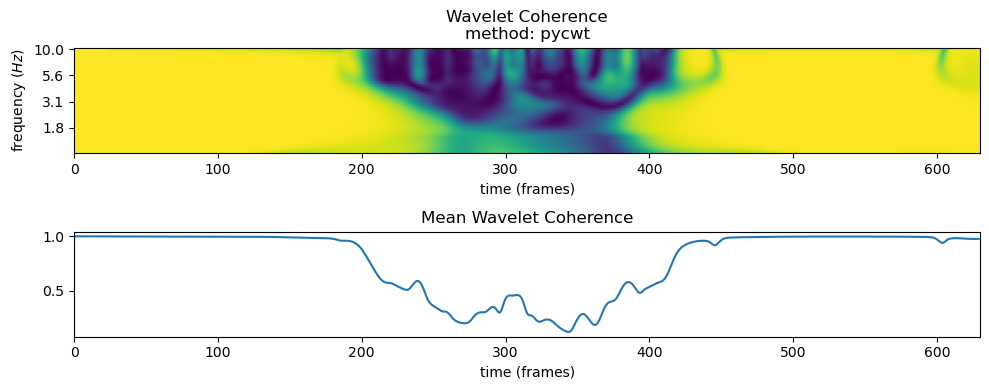

In [7]:
plot_wct(WCT, "Wavelet Coherence")

>
#### Wavelet Coherence without cone of influence

C:\Users\juigmend\AppData\Local\Temp\ipykernel_18672\476085976.py:24: RuntimeWarning: Mean of empty slice
  m_mean = np.nanmean(m,axis=0)


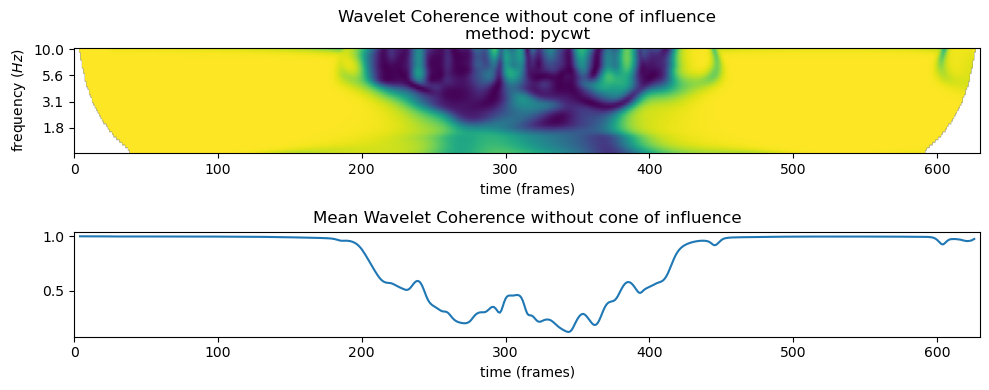

In [8]:
period = 1/freq_out
coi[ coi > 1/freq_out[-1] ] = np.nan
WCT_c = WCT.copy()
for i,t in enumerate(coi):
    if np.isnan(t): break
    row = np.argmin(abs(t-period))
    WCT_c[row:, (i,-i)] = np.nan
plot_wct(WCT_c, "Wavelet Coherence without cone of influence")